In [1]:
import numpy as np
# import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import h5py
import os
# import cmasher as cmr
# from collections import namedtuple
# from datetime import datetime
from scipy.optimize import curve_fit
import scipy.stats as stats
from fftest import fftest_2samp
from tqdm import tqdm

plt.style.use('/home/aussing/sty.mplstyle')
# mpl.rcParams.update(mpl.rcParamsDefault)

# Add additional paths for custom modules
# sys.path.insert(0, '/fred/oz381/cpower/analysistools')
# import merger_tree_tools as mtt
# import snapshot_tools as st
# import halo_tools as ht
# import galaxy_tools as gt
# import analysis_tools as at



In [2]:
# Configure plotting
# plt.style.use('/home/aussing/sty.mplstyle')
# cmap = cmr.torch

# # Define named tuple for organizing halo data
# HaloData = namedtuple('HaloData', [
#     'index', 'pos', 'mass', 'radius', 'structure_type', 
#     'gas_coords', 'gas_mass', 'dust_mass', 'metallicity'
# ])


In [3]:
# Physical constants
UNITMASS = 1e10  # Msun
LITTLEH = 0.6688  # Dimensionless Hubble parameter
GASTYPE    = 0
HIGHDMTYPE = 1
STARTYPE   = 4
LOWDMTYPE  = 5
UNIT_LENGTH_FOR_PLOTS = 'kpc'
SOLMASSINGRAMS = 1.989e+33
# LITTLEH = 1  # Dimensionless Hubble parameter

In [4]:
def get_sim_data(sim_directory,i_file):
    snap_fname     = f'/snapshot_{str(i_file).zfill(3)}.hdf5'
    snap_directory = sim_directory + snap_fname
    snap_data     = h5py.File(snap_directory, 'r')
    
    # haloinfo_fname     = f'/fof_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_fname     = f'/fof_subhalo_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_directory = sim_directory + haloinfo_fname
    haloinfo_data = h5py.File(haloinfo_directory, 'r')

    z = (snap_data['Header'].attrs['Redshift'])
    # print(z)
    return snap_data, haloinfo_data, z


In [5]:
def analytic_SMHM():
    from halotools.empirical_models import PrebuiltSubhaloModelFactory
    model = PrebuiltSubhaloModelFactory('behroozi10',redshift=0)
    halo_mass = np.logspace(11.5, 12.5, 100)
    # halo_mass = np.logspace(10, 14, 100)
    mean_sm = model.mean_stellar_mass(prim_haloprop = halo_mass)
    return halo_mass, mean_sm

In [6]:
def MWA_stellar_halo_mass(sim_directory,i_file):
    snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)
    halo_M200c     = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH 
    
    mass_mask = np.argsort(halo_M200c)[::-1]
    halo_mainID = np.where(halo_masstypes[mass_mask,LOWDMTYPE] == 0)[0][0]
    
    return halo_M200c[mass_mask[halo_mainID]], halo_masstypes[mass_mask[halo_mainID],4]


In [7]:
def stellar_mass_halo_mass(sim_directory,label,color,i_file):
        # print('\n',label)
        snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)

        halo_mass  = np.array(haloinfo_data['Group']['GroupMass'], dtype=np.float64) * UNITMASS / LITTLEH
        halo_M200c = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
        halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH

        # print(halo_masstypes)
        clean_haloes = np.where(halo_masstypes[:,5]==0)[0]

        plt.scatter(halo_M200c[clean_haloes],halo_masstypes[clean_haloes,4],label=label,color=color)


In [8]:
def get_unit_len(snapshot):
    unit_length = snapshot["Parameters"].attrs['UnitLength_in_cm']
    
    return unit_length


In [9]:
def set_plot_len(data, unit=UNIT_LENGTH_FOR_PLOTS):
    if unit in ['Mpc','mpc']:
        data = data/3.085678e24
    elif unit in ['Kpc','kpc']:
        data = data/3.085678e21
    elif unit == 'pc':
        data = data/3.085678e18
    else:
        print("What units do you want?????!!! AARRHH")
        raise TypeError
    return data

In [10]:
def get_snapshot(folder,snap_num,dm='cdm',SN_fac='sn_010'):
    return h5py.File(f"/fred/oz217/aussing/{folder}/{dm}/zoom/output/{SN_fac}/snapshot_{str(snap_num).zfill(3)}.hdf5")

def load_grid_data(folder,method,dm,SN_fac,snap_num):
    return np.load(f'/fred/oz217/aussing/clean_pd/powderday/{folder}/{method}/{dm}/{SN_fac}/snap_{str(snap_num).zfill(3)}/grid_physical_properties.{str(snap_num).zfill(3)}_galaxy0.npz')

In [11]:
def set_center(folder,dm,SN_fac,snap_num):
    halo_file = f"/fred/oz217/aussing/{folder}/{dm}/zoom/output/{SN_fac}/fof_subhalo_tab_{str(snap_num).zfill(3)}.hdf5"
    halo_data = h5py.File(halo_file, 'r')
    a = halo_data['Header'].attrs['Time']

    halo_pos   = np.array(halo_data['Group']['GroupPos'], dtype=np.float64) / LITTLEH
    halo_M200c = np.array(halo_data['Group']['Group_M_Crit200'], dtype=np.float64) / LITTLEH * UNITMASS
    halo_masstypes = np.array(halo_data['Group']['GroupMassType'], dtype=np.float64) / LITTLEH  * UNITMASS
    R200c = np.array(halo_data['Group']['Group_R_Crit200'], dtype=np.float64) / LITTLEH
    Group_SFR = np.array(halo_data['Group']['GroupSFR'], dtype=np.float64) 
    mass_mask = np.argsort(halo_M200c)[::-1] #Sort by most massive halo
    halo_mainID = np.where(halo_masstypes[mass_mask,5] == 0)[0][0] #Select largest non-contaminated halo / resimulation target
    
    # print(f'halo mass = {halo_M200c[mass_mask][halo_mainID]/UNITMASS*LITTLEH}e10')
    snapshot = get_snapshot(folder,snap_num,dm,SN_fac)
    unit_length = get_unit_len(snapshot)

    halo_pos = np.array(halo_pos[mass_mask][halo_mainID]) * unit_length
    halo_rad = R200c[mass_mask][halo_mainID] * unit_length
    stellar_mass = halo_masstypes[mass_mask][halo_mainID][4]
    gas_mass_200c = halo_masstypes[mass_mask][halo_mainID][0]
    sfr = Group_SFR[mass_mask][halo_mainID] 
    # print(f"stellar mass = {stellar_mass:.3e} Msun")
    # print(f"SFR          = {np.round(sfr,4)} Msun/yr")
    # print(f"Halo Rad = {halo_rad}, halo pos = {halo_pos}\n")
    # extent = halo_rad*2
    extent = halo_rad


    return halo_pos, extent, stellar_mass, sfr, gas_mass_200c, a

In [12]:
def get_extent(halo_pos,extent):

    xmin,xmax  = halo_pos[0]-extent,halo_pos[0]+extent
    ymin,ymax  = halo_pos[1]-extent,halo_pos[1]+extent
    zmin,zmax  = halo_pos[2]-extent,halo_pos[2]+extent
    
    return xmin,xmax,ymin,ymax,zmin,zmax

In [13]:
def make_mask(pos_x,pos_y,pos_z,halo_pos,extent):
    xmin,xmax,ymin,ymax,zmin,zmax = get_extent(halo_pos,extent)

    x_mask = (pos_x>=xmin) & (pos_x<=xmax)
    y_mask = (pos_y>=ymin) & (pos_y<=ymax)
    z_mask = (pos_z>=zmin) & (pos_z<=zmax)
    
    pos_mask = x_mask & y_mask & z_mask

    return pos_mask

In [14]:
def dust_mass(dm,SN_fac,label,folder,method,snap_num):
    # print(dm,'-',SN_fac)
    
    halo_pos, extent, stellar_mass, sfr, gas_mass_200c, a = set_center(folder,dm,SN_fac,snap_num)
    grid_physical_properties_data = load_grid_data(folder,method,dm,SN_fac,snap_num)
    
    pos_x = grid_physical_properties_data['gas_pos_x'] * 3.085678e18 / a# convert parsecs to cm, convert back later
    pos_y = grid_physical_properties_data['gas_pos_y'] * 3.085678e18 / a
    pos_z = grid_physical_properties_data['gas_pos_z'] * 3.085678e18 / a

    extent = np.float32(extent)
    extent_r200 = extent

    pos_mask_rad200 = make_mask(pos_x,pos_y,pos_z,halo_pos,extent_r200)

    extent_25kpc = 25 * 3.085678e21
    pos_mask_25kpc = make_mask(pos_x,pos_y,pos_z,halo_pos,extent_25kpc)
    
    extent_15kpc = 15 * 3.085678e21
    pos_mask_15kpc = make_mask(pos_x,pos_y,pos_z,halo_pos,extent_15kpc)


    dust_mass        = grid_physical_properties_data['particle_dustmass']#[pos_mask]
    dust_mass_rad200 = grid_physical_properties_data['particle_dustmass'][pos_mask_rad200]
    dust_mass_25kpc  = grid_physical_properties_data['particle_dustmass'][pos_mask_25kpc]
    dust_mass_15kpc  = grid_physical_properties_data['particle_dustmass'][pos_mask_15kpc]
    
    
    return dust_mass, np.sum(dust_mass_rad200), stellar_mass, sfr, gas_mass_200c

In [15]:
def power_law_fit(x_axis, alpha, beta):
    return alpha*x_axis**(beta)


In [16]:
folder_list = []
for simulation_name in [ simulation_name for simulation_name in os.listdir('/fred/oz217/aussing/') if ( simulation_name.startswith("N2048_L65_sd") )]:#and not simulation_name.startswith(("N2048_L65_sd12","N2048_L65_sd10")))]:#
    folder_list.append(simulation_name)

In [17]:
def moster_SMHM(z,halo_start=9.5,halo_end=12, num_points=20):
    
    M_10     = 11.59
    M_11     = 1.195
    N_10     = 0.0351
    N_11     = -0.0247
    beta_10  = 1.376
    beta_11  = -0.826
    gamma_10 = 0.608
    gamma_11 = 0.329

    log_M1  = M_10 + M_11 * ( z / (z + 1))
    N_z     = N_10 + N_11 * ( z / (z + 1))
    beta_z  = beta_10 + beta_11 * ( z / (z + 1))
    gamma_z = gamma_10 + gamma_11 * ( z / (z + 1))

    # halo_mass = np.logspace(halo_start,halo_end,20)
    halo_mass = np.geomspace(10**halo_start,10**halo_end,num_points)
    stellar_mass = halo_mass * 2 * N_z * ((halo_mass / 10**log_M1)**(-beta_z) + (halo_mass / 10**log_M1)**(gamma_z))**(-1)
    return halo_mass, stellar_mass



1.042e+11
1.125e+11


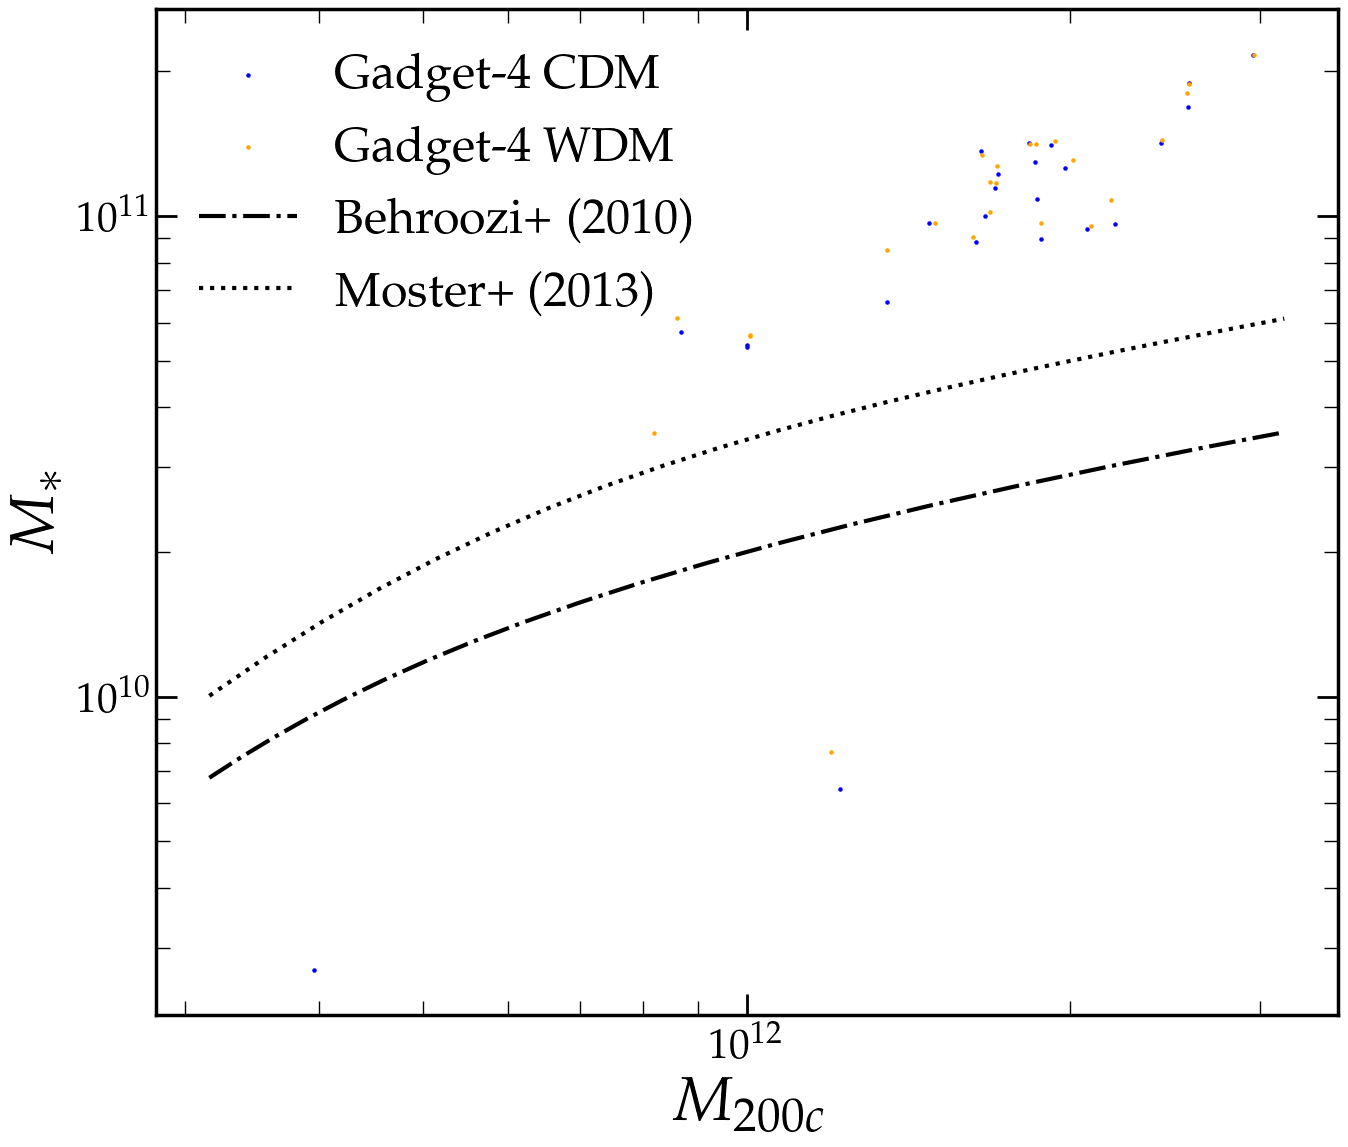

In [18]:

# swift_halo_mass    = np.array([r['halo_mass'] for r in cdm_results])
# swift_stellar_mass = np.array([r['Stellar_mass'] for r in cdm_results])
# swift_gas_mass     = np.array([r['gas_mass'] for r in cdm_results])
# swift_dust_mass    = np.array([r['dust_mass'] for r in cdm_results])

analytic_halo_mass, analytic_mean_sm = analytic_SMHM()

folder_list = np.sort(folder_list)
CDM_halo_mass, CDM_stellar_mass = [], []
WDM_halo_mass, WDM_stellar_mass = [], []

for folder in folder_list:
    # print(folder)
    cdm_file_loc = f'/fred/oz217/aussing/{folder}/cdm/zoom/output/sn_010/'
    wdm_file_loc = f'/fred/oz217/aussing/{folder}/wdm_3.5/zoom/output/sn_005/'
    # stellar_mass_halo_mass(cdm_file_loc,'','blue',26)
    # stellar_mass_halo_mass(wdm_file_loc,'','orange',26)
    try:
        CDM_halo_mass_iter, CDM_stellar_mass_iter = MWA_stellar_halo_mass(cdm_file_loc,26)
    except:
        print(f'Missing file in {folder}')
    CDM_halo_mass.append(CDM_halo_mass_iter)
    CDM_stellar_mass.append(CDM_stellar_mass_iter)
    
    try:
        WDM_halo_mass_iter, WDM_stellar_mass_iter = MWA_stellar_halo_mass(wdm_file_loc,26)
    except:
        print(f'Missing file in {folder}')
    WDM_halo_mass.append(WDM_halo_mass_iter)
    WDM_stellar_mass.append(WDM_stellar_mass_iter)

CDM_halo_mass = np.array(CDM_halo_mass)
CDM_stellar_mass = np.array(CDM_stellar_mass)


WDM_halo_mass = np.array(WDM_halo_mass)
WDM_stellar_mass = np.array(WDM_stellar_mass)

print(f'{np.median(CDM_stellar_mass):.3e}')
print(f'{np.median(WDM_stellar_mass):.3e}')

plt.scatter(CDM_halo_mass,CDM_stellar_mass,c='blue',label='Gadget-4 CDM',s=5)
plt.scatter(WDM_halo_mass,WDM_stellar_mass,c='orange',label='Gadget-4 WDM',s=5)
# plt.scatter(swift_halo_mass,swift_stellar_mass,c='r',label='SWIFT CDM')
plt.plot(analytic_halo_mass,analytic_mean_sm, label="Behroozi+ (2010)",color='k', ls='-.')
HM_moster, SM_moster = moster_SMHM(z=0,halo_start=11.5,halo_end=12.5)
plt.plot(HM_moster, SM_moster, label="Moster+ (2013)",color='k', ls=':')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$M_{200c}$')
plt.ylabel(r'$M_{*}$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()  
# plt.savefig(f'./post_sub_tests/combined_sm_hm.png',dpi=250)


In [31]:

# fig = plt.subplots()
method_list = ['rr']#,'li_bf']#'dtm']#,
cdm_sn = 'sn_010'
wdm_sn = 'sn_005'
for method in method_list:     
    # for sn in sn_list:
        # for dm in dm_list :          
    cdm_stel_dust_mass, cdm_sfr_dust_mass, cdm_gas_mass = [], [], []
    wdm_stel_dust_mass, wdm_sfr_dust_mass, wdm_gas_mass = [], [], []
    # fig=plt.subplots()
    for folder in folder_list:
        # print()
        # print(f'Simulation -> {folder}')
        
        snap_num = 22
        num_bins = 80

        cdm_dust_mass_total, cdm_dust_mass_rad200, cdm_stellar_mass, cdm_sfr, cdm_gas_mass_200c = dust_mass('cdm',cdm_sn,'',folder,method,snap_num)
        wdm_dust_mass_total, wdm_dust_mass_rad200, wdm_stellar_mass, wdm_sfr, wdm_gas_mass_200c = dust_mass('wdm_3.5',wdm_sn,'',folder,method,snap_num)

        cdm_stel_dust_mass.append((cdm_stellar_mass,cdm_dust_mass_rad200))
        cdm_sfr_dust_mass.append((cdm_sfr,cdm_dust_mass_rad200))
        
        wdm_stel_dust_mass.append((wdm_stellar_mass,wdm_dust_mass_rad200))
        wdm_sfr_dust_mass.append((wdm_sfr,wdm_dust_mass_rad200))

        cdm_gas_mass.append(cdm_gas_mass_200c)
        wdm_gas_mass.append(wdm_gas_mass_200c)
    
    cdm_stel_dust_mass = np.array(cdm_stel_dust_mass)
    wdm_stel_dust_mass = np.array(wdm_stel_dust_mass)

dust_mass_ks_test = stats.ks_2samp(cdm_stel_dust_mass[:,1],wdm_stel_dust_mass[:,1])
print(dust_mass_ks_test)

# plt.hist(cdm_stel_dust_mass[:,1],bins=np.logspace(7.5,8.2,15))
# plt.xscale('log')
# plt.show()
# plt.hist(wdm_stel_dust_mass[:,1],bins=np.logspace(7.5,8.2,15),alpha=0.5,color='orange')
# plt.xscale('log')
# plt.show()

KstestResult(statistic=0.4166666666666667, pvalue=0.029913567122680163, statistic_location=100895905.27333008, statistic_sign=-1)


In [20]:
starting_point_dsm = [10**-1.31,0.86]
# starting_point_dsm = None
# starting_point_dsm = [10**(- 2.84),1]

print(f'Fitting form y = alpha * (x ^ beta)\n')
cdm_best_fit_dsm,cdm_err_dsm = curve_fit(power_law_fit, cdm_stel_dust_mass[:,0], cdm_stel_dust_mass[:,1], p0=starting_point_dsm, maxfev=1000)
cdm_alpha_dsm, cdm_beta_dsm = cdm_best_fit_dsm[0], cdm_best_fit_dsm[1]
cdm_err_dsm = np.sqrt(np.diag(cdm_err_dsm))

print(f'CDM alpha = {cdm_alpha_dsm:.3e}, pm {cdm_err_dsm[0]:.3e}, or {cdm_err_dsm[0]/cdm_alpha_dsm*100}% ')
print(f'CDM beta  = {cdm_beta_dsm:.3e}, pm {cdm_err_dsm[1]:.3e}, or {cdm_err_dsm[1]/cdm_beta_dsm*100}% \n')

wdm_best_fit_dsm,wdm_err_dsm = curve_fit(power_law_fit, wdm_stel_dust_mass[:,0], wdm_stel_dust_mass[:,1], p0=starting_point_dsm, maxfev=1000)
wdm_alpha_dsm, wdm_beta_dsm = wdm_best_fit_dsm[0], wdm_best_fit_dsm[1]
wdm_err_dsm = np.sqrt(np.diag(wdm_err_dsm))

print(f'WDM alpha = {wdm_alpha_dsm:.3e}, pm {wdm_err_dsm[0]:.3e}, or {wdm_err_dsm[0]/wdm_alpha_dsm*100}% ')
print(f'WDM beta  = {wdm_beta_dsm:.3e}, pm {wdm_err_dsm[1]:.3e}, or {wdm_err_dsm[1]/wdm_beta_dsm*100}% ')



Fitting form y = alpha * (x ^ beta)

CDM alpha = 1.447e+06, pm 6.760e+06, or 467.12856959153595% 
CDM beta  = 1.520e-01, pm 1.847e-01, or 121.53669766908277% 

WDM alpha = 5.429e+07, pm 2.909e+08, or 535.773215560498% 
WDM beta  = 3.726e-03, pm 2.118e-01, or 5683.992177738722% 


In [21]:
grossi_2015 = np.loadtxt('./dust_data/grossi-2015.txt',dtype=np.float64)
salvestrini_2025 = np.loadtxt('./dust_data/Salvestrini-2025.txt',dtype=np.float64)
remy_ruyer_2015 = np.loadtxt('./dust_data/remy-ruyer-2015.txt',dtype=np.float64)
du_cunha_2015 = np.loadtxt('./dust_data/da-cunha-2015.txt',dtype=np.float64)

# print(np.array(data).shape)

0.5051814855409227 0.9858843791205468


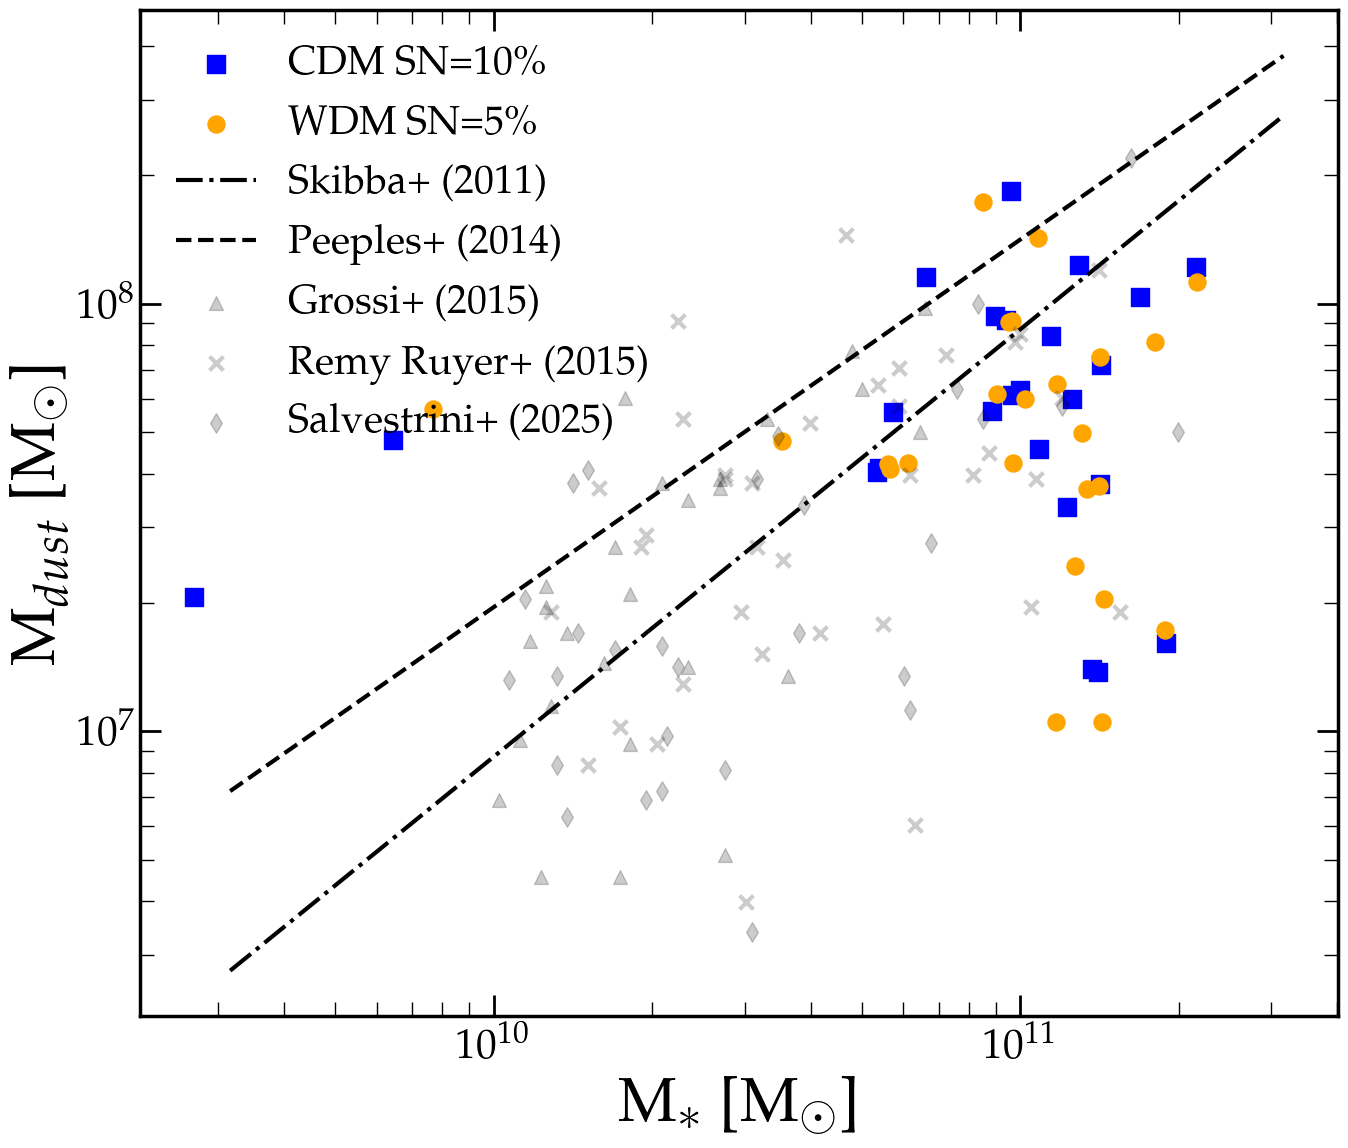

In [22]:

plt.close()
fig, ax = plt.subplots()
log_stellar_mass = np.logspace(9.5,11.5,100,base=10)+10**0.23 

plt.scatter((cdm_stel_dust_mass[:,0]),(cdm_stel_dust_mass[:,1]),c='blue', label='CDM SN=10\%' ,s=150,marker='s')
plt.scatter((wdm_stel_dust_mass[:,0]),(wdm_stel_dust_mass[:,1]),c='orange', label='WDM SN=5\%',s=150,marker='o')
# plt.plot(log_stellar_mass, cdm_alpha_dsm*log_stellar_mass**cdm_beta_dsm,c='blue',alpha=0.7)

# plt.plot(log_stellar_mass, wdm_alpha_dsm*log_stellar_mass**wdm_beta_dsm,c='orange',alpha=0.7)

               
peeples_14_fit = (log_stellar_mass)**0.86 * 10**-1.31
skibba_11_bar_fit  = log_stellar_mass *10**(- 2.84)
skibba_11_nobar_fit  = log_stellar_mass *10**(- 3.06)
clemens_13_stellar_fit = log_stellar_mass *10**(- 2.34)
# clemens_13_stellar_fit = log_stellar_mass * 4.6e-3
# cortese_masses = np.array([8.62 , 9.06 , 9.48 , 9.99 , 10.46, 10.91])+0.23
# cortese_DTS = np.array(   [-2.19, -2.24, -2.39, -2.87, -3.68, -3.34])
cortese_masses = np.array([ 10**9.48 , 10**9.99 , 10**10.46, 10**10.91])+10**0.23
cortese_DTS = np.array(   [ 10**-2.39, 10**-2.87, 10**-3.68, 10**-3.34])

plt.plot(log_stellar_mass,skibba_11_nobar_fit,c='k',ls='-.',label='Skibba+ (2011)') ## NO BAR
# plt.plot(log_stellar_mass,clemens_13_stellar_fit,c='k',ls=':',label='Clemens+ (2013)')
plt.plot(log_stellar_mass,peeples_14_fit,c='k',ls='--',label='Peeples+ (2014)')
# plt.scatter(cortese_masses, cortese_masses*cortese_DTS, s=200,marker="+",c='k', label='Cortese+ (2012)')

# plt.plot(log_stellar_mass,skibba_11_bar_fit,c='k',ls=':',label='Skibba+11 barred')

plt.scatter(10**grossi_2015[:,0][grossi_2015[:,0]>10.0],          10**grossi_2015[:,2][grossi_2015[:,0]>10.0]          ,c='k',s=100,alpha=0.2,marker='^',label='Grossi+ (2015)')
plt.scatter(10**remy_ruyer_2015[:,0][remy_ruyer_2015[:,0]>10.0]  ,10**remy_ruyer_2015[:,2][remy_ruyer_2015[:,0]>10.0]  ,c='k',s=100,alpha=0.2,marker='x',label='Remy Ruyer+ (2015)')
# plt.scatter(10**remy_ruyer_2015[:,0][remy_ruyer_2015[:,0]>10.0]  ,10**remy_ruyer_2015[:,3][remy_ruyer_2015[:,0]>10.0]  ,c='k',s=50,alpha=0.2,marker='X',label='Remy Ruyer+15 AC')
# plt.scatter(10**du_cunha_2015[:,0][du_cunha_2015[:,0]>10.0],      10**du_cunha_2015[:,2][du_cunha_2015[:,0]>10.0],      c='k',s=70,alpha=0.2,marker='o',label='Da Cunha+ (2015)')
plt.scatter(10**salvestrini_2025[:,0][salvestrini_2025[:,0]>10.0],10**salvestrini_2025[:,2][salvestrini_2025[:,0]>10.0],c='k',s=100,alpha=0.2,marker='d',label='Salvestrini+ (2025)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'M$_{*}$ [M$_{\odot}$]')
plt.ylabel(r'M$_{{dust}}$ [M$_{\odot}$]')
plt.legend(loc='upper left',fontsize='large')
plt.tight_layout()

Dn, pval = fftest_2samp(cdm_stel_dust_mass, wdm_stel_dust_mass, n_perms=100, seed=1222)

print(Dn, pval)

# plt.show()
plt.savefig(f'./dust_corrs/stellar_dust_mass_{method}_{snap_num}.png',dpi=250)




CDM alpha = 9.308e+03, pm 1.136e+04, or 121.99237010270103% 
CDM beta  = -6.392e-01, pm 5.436e-02, or -8.504183458416883% 

WDM alpha = 4.033e+07, pm 5.671e+07, or 140.59219307808968% 
WDM beta  = -9.853e-01, pm 6.079e-02, or -6.1698607553477585% 
0.5773502691896258 0.976397839922974


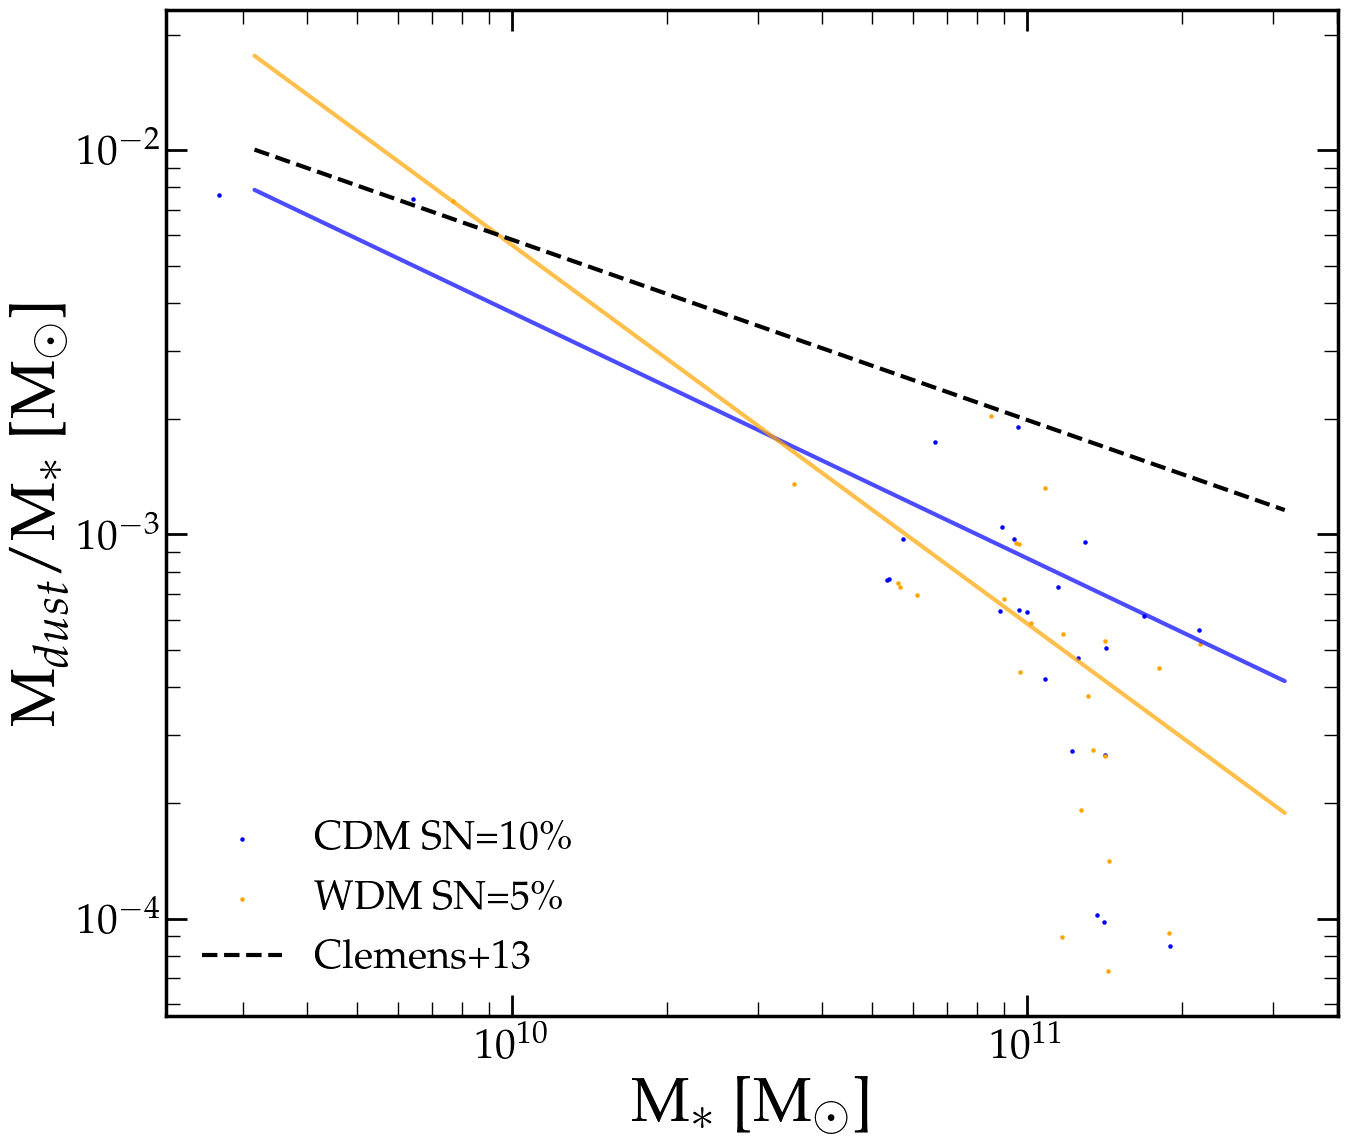

In [23]:
plt.close()
# fig, ax = plt.subplots()
starting_point_dsm_sm = [10**(2.457), -0.469]
cdm_best_fit_dsm,cdm_err_dsm = curve_fit(power_law_fit, cdm_stel_dust_mass[:,0], (cdm_stel_dust_mass[:,1])/(cdm_stel_dust_mass[:,0]), p0=starting_point_dsm_sm, maxfev=1000)
cdm_alpha_dsm, cdm_beta_dsm = cdm_best_fit_dsm[0], cdm_best_fit_dsm[1]
cdm_err_dsm = np.sqrt(np.diag(cdm_err_dsm))

print(f'CDM alpha = {cdm_alpha_dsm:.3e}, pm {cdm_err_dsm[0]:.3e}, or {cdm_err_dsm[0]/cdm_alpha_dsm*100}% ')
print(f'CDM beta  = {cdm_beta_dsm:.3e}, pm {cdm_err_dsm[1]:.3e}, or {cdm_err_dsm[1]/cdm_beta_dsm*100}% \n')

wdm_best_fit_dsm,wdm_err_dsm = curve_fit(power_law_fit, wdm_stel_dust_mass[:,0], (wdm_stel_dust_mass[:,1])/(wdm_stel_dust_mass[:,0]), p0=starting_point_dsm_sm, maxfev=1000)
wdm_alpha_dsm, wdm_beta_dsm = wdm_best_fit_dsm[0], wdm_best_fit_dsm[1]
wdm_err_dsm = np.sqrt(np.diag(wdm_err_dsm))

print(f'WDM alpha = {wdm_alpha_dsm:.3e}, pm {wdm_err_dsm[0]:.3e}, or {wdm_err_dsm[0]/wdm_alpha_dsm*100}% ')
print(f'WDM beta  = {wdm_beta_dsm:.3e}, pm {wdm_err_dsm[1]:.3e}, or {wdm_err_dsm[1]/wdm_beta_dsm*100}% ')

cdm_dsm_t_sm = cdm_stel_dust_mass.copy()
cdm_dsm_t_sm[:,1] = cdm_dsm_t_sm[:,1]/cdm_stel_dust_mass[:,0]

wdm_dsm_t_sm = wdm_stel_dust_mass.copy()
wdm_dsm_t_sm[:,1] = wdm_dsm_t_sm[:,1]/wdm_stel_dust_mass[:,0]

Dn, pval = fftest_2samp(cdm_dsm_t_sm, wdm_dsm_t_sm, n_perms=100, seed=1111)
print(Dn, pval)

log_stellar_mass = np.logspace(9.5,11.5,100,base=10)+10**0.23 

plt.scatter(cdm_dsm_t_sm[:,0],cdm_dsm_t_sm[:,1],c='blue', label='CDM SN=10\%',s=5)
plt.plot(log_stellar_mass, cdm_alpha_dsm*log_stellar_mass**cdm_beta_dsm,c='blue',alpha=0.7)

plt.scatter(wdm_dsm_t_sm[:,0],wdm_dsm_t_sm[:,1],c='orange', label='WDM SN=5\%',s=5)
plt.plot(log_stellar_mass, wdm_alpha_dsm*log_stellar_mass**wdm_beta_dsm,c='orange',alpha=0.7)

clemens_13 = 10**(2.457)*log_stellar_mass**-0.469
plt.plot(log_stellar_mass, clemens_13, c='k',ls='--',label='Clemens+13')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'M$_{*}$ [M$_{\odot}$]')
plt.ylabel(r'M$_{{dust}}$/M$_{*}$ [M$_{\odot}$]')
plt.legend(loc='lower left',fontsize='large')
plt.tight_layout()
plt.show()
# plt.savefig(f'./dust_corrs/DtS_vs_SM_{method}.png',dpi=250)
    

CDM alpha = 8.402e-04, pm 6.961e-03, or 828.4959713689925% 
CDM beta  = 9.748e-01, pm 3.197e-01, or 32.79195249314852% 



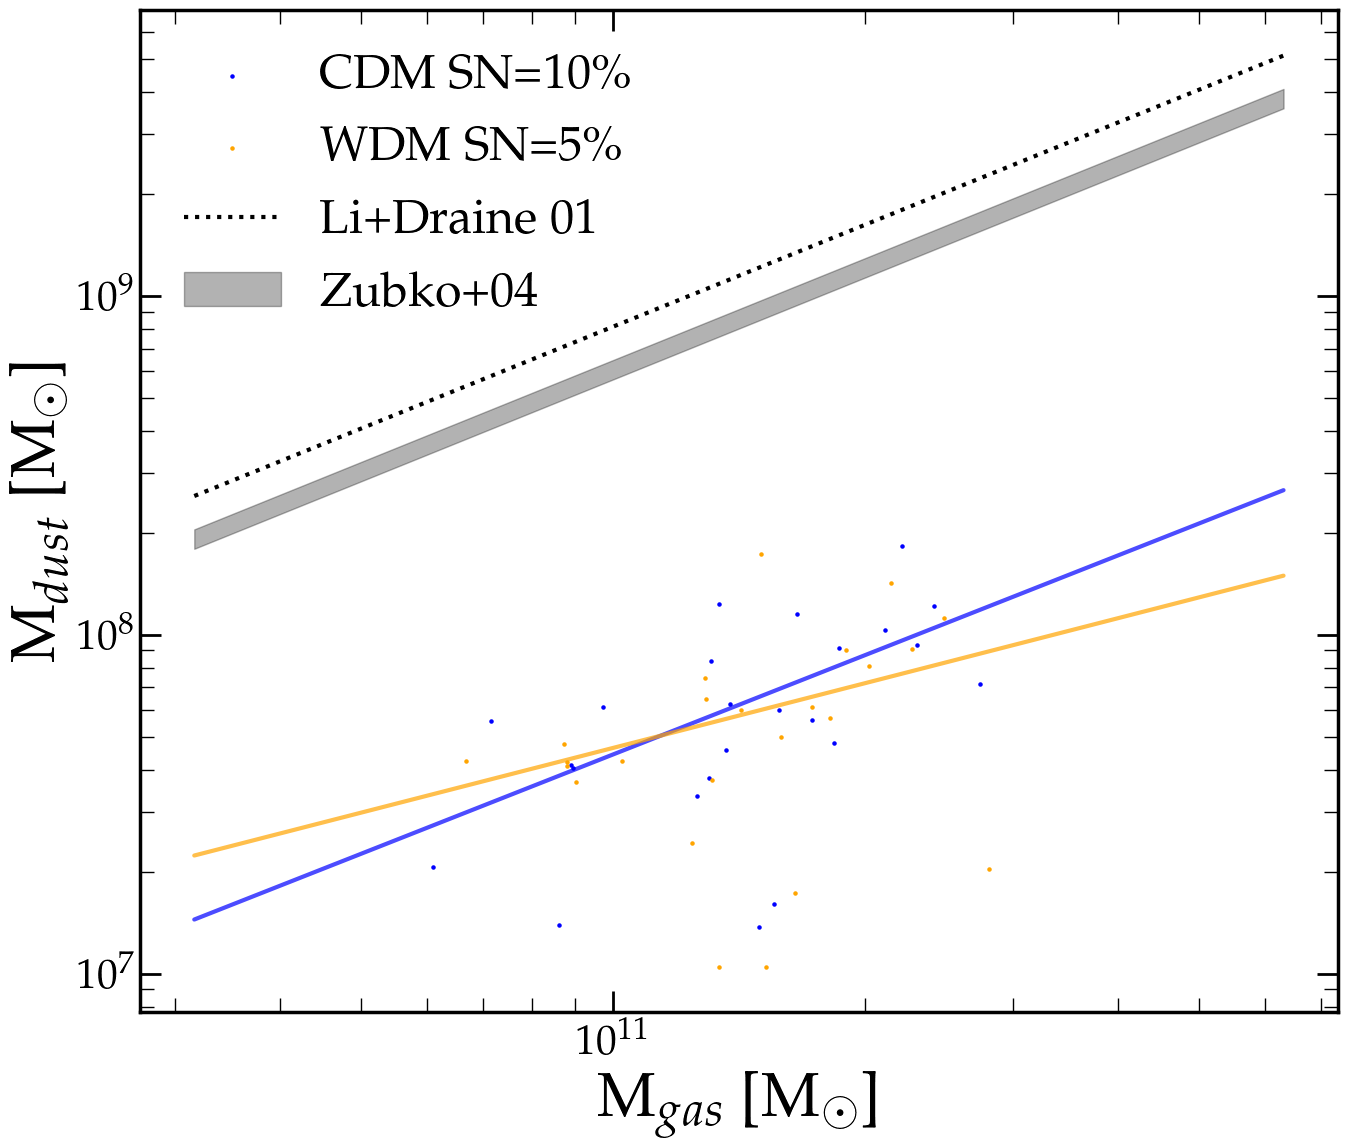

In [24]:
starting_point_dsm_sm = [0.00813, 1]
cdm_best_fit_dsm,cdm_err_dsm = curve_fit(power_law_fit, (cdm_gas_mass),(cdm_stel_dust_mass[:,1]), p0=starting_point_dsm_sm, maxfev=1000)
cdm_alpha_dsm, cdm_beta_dsm = cdm_best_fit_dsm[0], cdm_best_fit_dsm[1]
cdm_err_dsm = np.sqrt(np.diag(cdm_err_dsm))

print(f'CDM alpha = {cdm_alpha_dsm:.3e}, pm {cdm_err_dsm[0]:.3e}, or {cdm_err_dsm[0]/cdm_alpha_dsm*100}% ')
print(f'CDM beta  = {cdm_beta_dsm:.3e}, pm {cdm_err_dsm[1]:.3e}, or {cdm_err_dsm[1]/cdm_beta_dsm*100}% \n')

wdm_best_fit_dsm,wdm_err_dsm = curve_fit(power_law_fit, (wdm_gas_mass),(wdm_stel_dust_mass[:,1]), p0=starting_point_dsm_sm, maxfev=1000)
wdm_alpha_dsm, wdm_beta_dsm = wdm_best_fit_dsm[0], wdm_best_fit_dsm[1]
wdm_err_dsm = np.sqrt(np.diag(wdm_err_dsm))

# fig=plt.subplots()
cdm_gas_mass = np.array(cdm_gas_mass)
wdm_gas_mass = np.array(wdm_gas_mass)

plt.scatter((cdm_gas_mass),(cdm_stel_dust_mass[:,1]),c='blue', label='CDM SN=10\%',s=5)
plt.scatter((wdm_gas_mass),(wdm_stel_dust_mass[:,1]),c='orange', label='WDM SN=5\%',s=5)

log_gas_mass = np.logspace(10.5,11.8,100)

plt.plot(log_gas_mass, cdm_alpha_dsm*log_gas_mass**cdm_beta_dsm,c='blue',alpha=0.7)
plt.plot(log_gas_mass, wdm_alpha_dsm*log_gas_mass**wdm_beta_dsm,c='orange',alpha=0.7)

# plt.scatter(np.log10(swift_gas_mass),np.log10(swift_dust_mass),c='red', label='SWIFT CDM')


li_draine_01 = log_gas_mass*(0.00813)
zubko_04_min = log_gas_mass*(0.00568)
zubko_04_max = log_gas_mass*(0.00648)

plt.plot(log_gas_mass,li_draine_01,color='k',ls=':',label='Li+Draine 01')
plt.fill_between(log_gas_mass,zubko_04_min,zubko_04_max,alpha=0.3,color='k',label='Zubko+04')
# plt.plot(log_gas_mass,zubko_04_max,c='k',ls='-.',label='Zubko+04 max')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'M$_{gas}$ [M$_{\odot}$]')
plt.ylabel(r'M$_{dust}$ [M$_{\odot}$]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
# plt.savefig(f'./dust_corrs/gas_dust_mass_{method}.png',dpi=250)


In [25]:
cdm_sfr_dust_mass  = np.array(cdm_sfr_dust_mass)
wdm_sfr_dust_mass  = np.array(wdm_sfr_dust_mass)

starting_point = [1.28e7, 1.11]

print(f'Fitting form y = alpha * (x ^ beta)\n')
cdm_best_fit,cdm_err = curve_fit(power_law_fit, (cdm_sfr_dust_mass[:,0]), (cdm_sfr_dust_mass[:,1]), p0=starting_point)
cdm_alpha, cdm_beta = cdm_best_fit[0], cdm_best_fit[1]
cdm_err = np.sqrt(np.diag(cdm_err))

print(f'CDM alpha = {cdm_alpha:.3e}, pm {cdm_err[0]:.3e}, or {cdm_err[0]/cdm_alpha*100:.3}% ')
print(f'CDM beta  = {cdm_beta:.3e}, pm {cdm_err[1]:.3e}, or {cdm_err[1]/cdm_beta*100:.3}% \n')

wdm_best_fit,wdm_err = curve_fit(power_law_fit, (wdm_sfr_dust_mass[:,0]), (wdm_sfr_dust_mass[:,1]), p0=starting_point)
wdm_alpha, wdm_beta = wdm_best_fit[0], wdm_best_fit[1]
wdm_err = np.sqrt(np.diag(wdm_err))

print(f'WDM alpha = {wdm_alpha:.3e}, pm {wdm_err[0]:.3e}, or {wdm_err[0]/wdm_alpha*100:.3}% ')
print(f'WDM beta  = {wdm_beta:.3e}, pm {wdm_err[1]:.3e}, or {wdm_err[1]/wdm_beta*100:.3}% ')



Fitting form y = alpha * (x ^ beta)

CDM alpha = 3.130e+07, pm 5.703e+06, or 18.2% 
CDM beta  = 6.518e-01, pm 1.016e-01, or 15.6% 

WDM alpha = 2.381e+07, pm 4.545e+06, or 19.1% 
WDM beta  = 7.190e-01, pm 9.522e-02, or 13.2% 


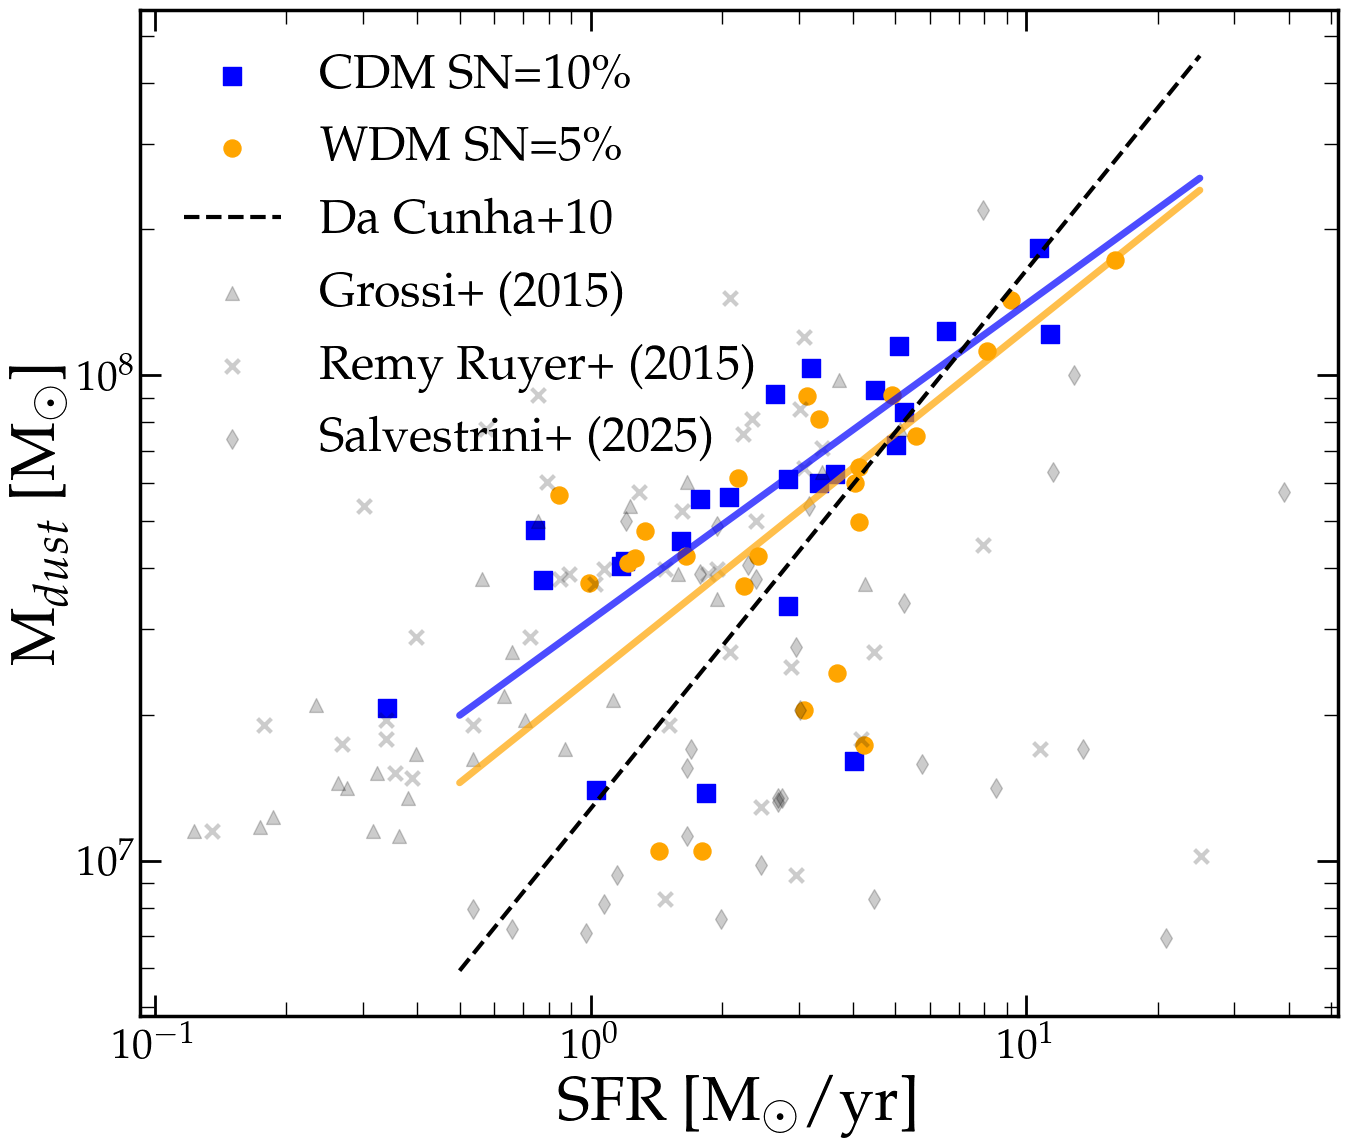

In [26]:
sfr_space   = np.geomspace(0.5,25,10)
da_cunha_10_dust_mass = 1.28e7 * sfr_space**1.11


cdm_fit = cdm_alpha*sfr_space**cdm_beta
plt.plot(sfr_space,cdm_fit,c='blue',alpha=0.7,lw=5)

wdm_fit = wdm_alpha*sfr_space**wdm_beta
plt.plot(sfr_space,wdm_fit,c='orange',alpha=0.7,lw=5)

plt.scatter(cdm_sfr_dust_mass[:,0],cdm_sfr_dust_mass[:,1],c='blue',   label="CDM SN=10\%",s=150,marker='s')
plt.scatter(wdm_sfr_dust_mass[:,0],wdm_sfr_dust_mass[:,1],c='orange', label='WDM SN=5\%' ,s=150,marker='o')
plt.plot(sfr_space,da_cunha_10_dust_mass,c='k',ls='--', label='Da Cunha+10')

grossi_mask = (np.array(grossi_2015[:,1])>-0.5) & (np.array(grossi_2015[:,1])<1.5)
remy_ruyer_mask = (np.array(remy_ruyer_2015[:,1])>-0.5) & (np.array(remy_ruyer_2015[:,1])<1.5)

plt.scatter(10**grossi_2015[:,1][grossi_2015[:,2]>7],          10**grossi_2015[:,2][grossi_2015[:,2]>7],          c='k',s=100,alpha=0.2,marker='^',label='Grossi+ (2015)')
# plt.scatter(10**grossi_2015[:,1][grossi_mask],          10**grossi_2015[:,2][grossi_mask],          c='k',s=100,alpha=0.2,marker='^',label='Grossi+ (2015)')

plt.scatter(10**remy_ruyer_2015[:,1][remy_ruyer_2015[:,2]>6.8],  10**remy_ruyer_2015[:,2][remy_ruyer_2015[:,2]>6.8],  c='k',s=100,alpha=0.2,marker='x',label='Remy Ruyer+ (2015)')
# plt.scatter(10**remy_ruyer_2015[:,1][remy_ruyer_mask],  10**remy_ruyer_2015[:,2][remy_ruyer_mask],  c='k',s=100,alpha=0.2,marker='x',label='Remy Ruyer+ (2015)')

# plt.scatter(10**remy_ruyer_2015[:,0][remy_ruyer_2015[:,0]>10.0]  ,10**remy_ruyer_2015[:,3][remy_ruyer_2015[:,0]>10.0]  ,c='k',s=50,alpha=0.2,marker='X',label='Remy Ruyer+15 AC')
# plt.scatter(10**du_cunha_2015[:,1],      10**du_cunha_2015[:,2],      c='k',s=70,alpha=0.2,marker='o',label='Da Cunha+ (2015)')
plt.scatter(10**salvestrini_2025[:,1][salvestrini_2025[:,2]>6.8],10**salvestrini_2025[:,2][salvestrini_2025[:,2]>6.8],c='k',s=100,alpha=0.2,marker='d',label='Salvestrini+ (2025)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"SFR [M$_{\odot}$/yr]")
plt.ylabel(r"M$_{{dust}}$ [M$_{\odot}$]")
plt.legend(loc='upper left')
plt.tight_layout()
# plt.show()
plt.savefig(f'./dust_corrs/SFR_dust_mass_{method}_{snap_num}.png',dpi=250)  

In [27]:
Dn, pval = fftest_2samp(cdm_sfr_dust_mass, wdm_sfr_dust_mass, n_perms=100, seed=1111)
print(Dn, pval)

0.5773502691896258 0.9630715573294601


In [28]:
def express_set_center(folder,dm,SN_fac,snap_num):
    halo_file = f"/fred/oz217/aussing/{folder}/{dm}/zoom/output/{SN_fac}/fof_subhalo_tab_{str(snap_num).zfill(3)}.hdf5"
    halo_data = h5py.File(halo_file, 'r')
    a = halo_data['Header'].attrs['Time']

    halo_pos   = np.array(halo_data['Group']['GroupPos'], dtype=np.float64) / LITTLEH
    halo_M200c = np.array(halo_data['Group']['Group_M_Crit200'], dtype=np.float64) / LITTLEH * UNITMASS
    halo_masstypes = np.array(halo_data['Group']['GroupMassType'], dtype=np.float64) / LITTLEH  * UNITMASS
    R200c = np.array(halo_data['Group']['Group_R_Crit200'], dtype=np.float64) / LITTLEH

    mass_mask = np.argsort(halo_M200c)[::-1] 
    halo_mainID = np.where(halo_masstypes[mass_mask,5] == 0)[0][0] 

    halo_pos = np.array(halo_pos[mass_mask][halo_mainID]) * 1000.0 #* unit_length
    halo_rad = R200c[mass_mask][halo_mainID] * 1000.0 #* unit_length
    return halo_pos, halo_rad, a

def express_dust_mass(dm,SN_fac,label,folder,method,snap_num):
    # print(dm,'-',SN_fac)
    
    halo_pos, extent_r200 , a = express_set_center(folder,dm,SN_fac,snap_num)
    grid_physical_properties_data = load_grid_data(folder,method,dm,SN_fac,snap_num)
    
    pos_x = grid_physical_properties_data['gas_pos_x'] / 1000.0 / a 
    pos_y = grid_physical_properties_data['gas_pos_y'] / 1000.0 / a
    pos_z = grid_physical_properties_data['gas_pos_z'] / 1000.0 / a
    
    pos_mask_rad200 = make_mask(pos_x,pos_y,pos_z,halo_pos,extent_r200)
    dust_mass_rad200 = np.sum(grid_physical_properties_data['particle_dustmass'][pos_mask_rad200])
    
    return dust_mass_rad200

In [29]:
method_list = ['dtm','rr','li_bf']
cdm_sn = 'sn_010'
wdm_sn = 'sn_005'
ks_results = []
cdm_wdm_ratio_all = []

for method in method_list:  
    print(f'Method = {method}')   
    snap_list = np.arange(5,27,1)
    ks_results_per_method = []
    cdm_wdm_ratio_per_method = []
    continue
    for snap_num in snap_list:
        print(f'Snap num = {snap_num}')
        cdm_dust_r_200 = []
        wdm_dust_r_200 = []
        cdm_wdm_ratio_per_snap  = []

        for folder in folder_list:
            # print(f'Simulation -> {folder}')
            cdm_dust_mass_rad200 = express_dust_mass('cdm',cdm_sn,'',folder,method,snap_num)
            wdm_dust_mass_rad200 = express_dust_mass('wdm_3.5',wdm_sn,'',folder,method,snap_num)
            
            cdm_dust_mass_rad200 = np.log10( cdm_dust_mass_rad200)
            wdm_dust_mass_rad200 = np.log10( wdm_dust_mass_rad200)
            
            ratio = (cdm_dust_mass_rad200/wdm_dust_mass_rad200-1)*100
            # log_ratio = np.log10(cdm_dust_mass_rad200/wdm_dust_mass_rad200)
            
            cdm_dust_r_200.append(cdm_dust_mass_rad200)
            wdm_dust_r_200.append(wdm_dust_mass_rad200)
            cdm_wdm_ratio_per_snap.append(ratio)
        
        cdm_dust_r_200 = np.array(cdm_dust_r_200)    
        wdm_dust_r_200 = np.array(wdm_dust_r_200)    
        cdm_wdm_ratio_per_snap = np.array(cdm_wdm_ratio_per_snap)

        cdm_wdm_ratio_per_method.append(cdm_wdm_ratio_per_snap)
        ks_results_per_method.append(stats.ks_2samp(cdm_dust_r_200,wdm_dust_r_200)[1])
    
    cdm_wdm_ratio_per_method = np.array(cdm_wdm_ratio_per_method)    
    cdm_wdm_ratio_all.append(cdm_wdm_ratio_per_method)

    ks_results_per_method = np.array(ks_results_per_method)
    ks_results.append(ks_results_per_method)                     



Method = dtm
Method = rr
Method = li_bf


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

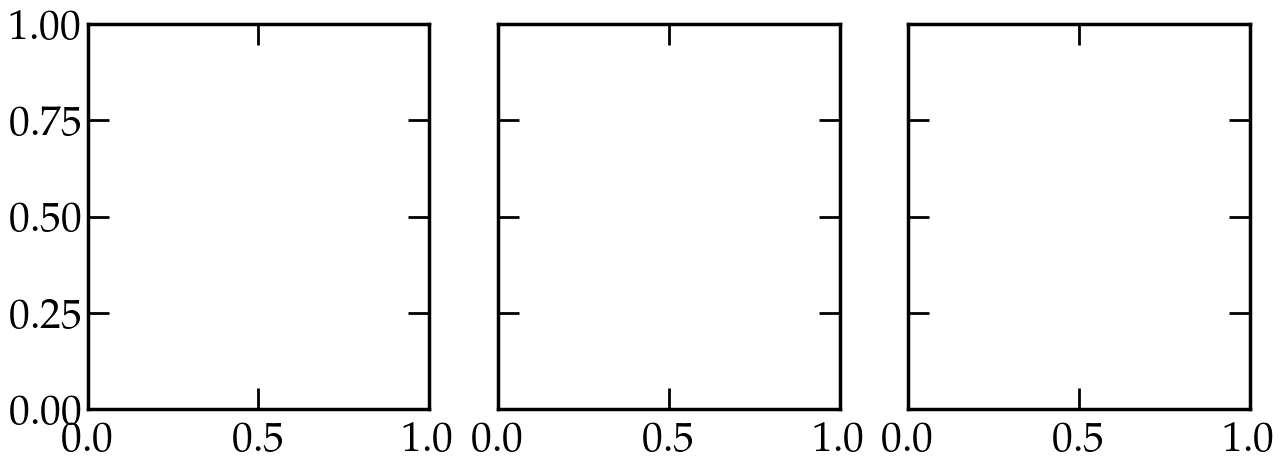

In [30]:
plt.close()

fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(15,5))

cdm_wdm_ratio_all = np.array(cdm_wdm_ratio_all)
ax1.violinplot(dataset=cdm_wdm_ratio_all[0,:,:].T,positions=np.array(snap_list),showmedians=True,showextrema=False)#, vert=True)#orientation='vertical')
median = []
for i in range(22):
    median.append(np.median(cdm_wdm_ratio_all[0,i,:]))
ax1.plot(snap_list,median)

ax2.violinplot(dataset=cdm_wdm_ratio_all[1,:,:].T,positions=np.array(snap_list),showmedians=True,showextrema=False)
median = []
for i in range(22):
    median.append(np.median(cdm_wdm_ratio_all[1,i,:]))
ax2.plot(snap_list,median)

ax3.violinplot(dataset=cdm_wdm_ratio_all[2,:,:].T,positions=np.array(snap_list),showmedians=True,showextrema=False)
median = []
for i in range(22):
    median.append(np.median(cdm_wdm_ratio_all[2,i,:]))
ax3.plot(snap_list,median)

ax1.axhline(0, color='k',ls=':')
ax1.set_title('DTM')

ax2.axhline(0, color='k',ls=':')
ax2.set_title('RR - DTG')

ax3.axhline(0, color='k',ls=':')
ax3.set_title('LI - BF')

plt.ylim(-10,10)
# plt.yscale('symlog')
ax1.set_ylabel('log(CDM) / log(WDM)')
# plt.xlabel('snap_num')
# plt.yscale('log')

plt.show()
plt.close()


ks_results = np.array(ks_results)
# print(ks_results,ks_results.shape)
plt.plot(snap_list,ks_results[0,:])
plt.plot(snap_list,ks_results[1,:])
plt.plot(snap_list,ks_results[2,:])
plt.hlines(0.05,5,26, color='k',ls=':')
plt.ylabel('P-value')
plt.xlabel('snap_num')
# plt.yscale('log')
plt.show()


In [ ]:
# print(dtm_violin['bodies']['cmedians'])